### Selección de variables de acuerdo con los metodos vistos en clase

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib as mpl
import matplotlib.cm as cm
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 10
from Funciones import *

In [2]:
ruta_base  = os.path.dirname(os.path.abspath('./')) + '/'
ruta_datos = ruta_base + 'Datos/'
ruta_shp   = ruta_datos+ 'Shapefiles/'
ruta_imagenes = ruta_base + 'Imagenes/'

In [3]:
# Carga información y elimina datos nans

datos_anomalias_rez = pd.read_csv(ruta_datos+'Anomalias_rezagadas_datos.csv', index_col=0, parse_dates=True)
datos_anomalias_rez = datos_anomalias_rez.iloc[~datos_anomalias_rez.isna().any(axis=1).values,:]

In [4]:
#datos_anomalias_rez.head(5)

In [5]:
#datos_anomalias_rez.tail(5)

In [6]:
print(datos_anomalias_rez.shape)

(6497, 19)


### Solo tener en cuenta los datos de train

In [7]:
f_train = '2016-12-31'
f_test  = '2017-01-01'

datos_anomalias_train = datos_anomalias_rez[:f_train]
datos_anomalias_test  = datos_anomalias_rez[f_test:]

### Definición de variables independientes y dependiente

In [8]:
X = datos_anomalias_train.drop(['Caudal'],axis=1)
y = datos_anomalias_train['Caudal']

### Selección con base en la varianza

In [9]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.5)
selector.fit(X)
seleccionadas = X.columns[selector.get_support()]
print(len(seleccionadas))
print(seleccionadas)

18
Index(['EIG_a', 'ER_s_2', 'Kelvin_s_1', 'MJO_s', 'MJO_a', 'MRG_a_1', 'TD_s_1',
       'WIG_s', 'CARIBE_u_1', 'CARIBE_v', 'CHOCO_u_2', 'CHOCO_v_1',
       'ORINOQUIA_u_3', 'ORINOQUIA_v_3', 'PPT_ERA5_1', 'PPT_ERA_acum',
       'Tendencia', 'Caudal_antes'],
      dtype='object')


Por este lado, todas sirven.

### Kbest con información mutua y lineal

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression, f_regression

In [11]:
variables = SelectKBest(score_func=mutual_info_regression, k=10)
variables.fit(X,y)
X.columns[variables.get_support()]

Index(['MJO_s', 'MJO_a', 'TD_s_1', 'CARIBE_u_1', 'CHOCO_u_2', 'ORINOQUIA_v_3',
       'PPT_ERA5_1', 'PPT_ERA_acum', 'Tendencia', 'Caudal_antes'],
      dtype='object')

In [12]:
variables = SelectKBest(score_func=f_regression, k=10)
variables.fit(X,y)
X.columns[variables.get_support()]

Index(['Kelvin_s_1', 'CARIBE_u_1', 'CHOCO_u_2', 'CHOCO_v_1', 'ORINOQUIA_u_3',
       'ORINOQUIA_v_3', 'PPT_ERA5_1', 'PPT_ERA_acum', 'Tendencia',
       'Caudal_antes'],
      dtype='object')

### Eliminación de variables recursiva

In [13]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [14]:
rfe=RFE(estimator=LinearRegression(),n_features_to_select = 1, step = 1)
fit=rfe.fit(X,y)
print(fit.n_features_)
print(X.columns[fit.support_])

pos = np.argsort(fit.ranking_)
print(X.columns[pos])
print(X.columns[pos][:10])

1
Index(['Caudal_antes'], dtype='object')
Index(['Caudal_antes', 'PPT_ERA5_1', 'Tendencia', 'PPT_ERA_acum', 'CARIBE_u_1',
       'EIG_a', 'TD_s_1', 'Kelvin_s_1', 'CARIBE_v', 'WIG_s', 'ORINOQUIA_u_3',
       'CHOCO_v_1', 'MRG_a_1', 'ORINOQUIA_v_3', 'MJO_s', 'ER_s_2', 'CHOCO_u_2',
       'MJO_a'],
      dtype='object')
Index(['Caudal_antes', 'PPT_ERA5_1', 'Tendencia', 'PPT_ERA_acum', 'CARIBE_u_1',
       'EIG_a', 'TD_s_1', 'Kelvin_s_1', 'CARIBE_v', 'WIG_s'],
      dtype='object')


### Seleccionar desde un modelo

In [15]:
from sklearn.feature_selection import SelectFromModel
sfm_selector = SelectFromModel(estimator= LinearRegression())
sfm_selector.fit(X, y)
X.columns[sfm_selector.get_support()]

Index(['PPT_ERA5_1', 'Tendencia', 'Caudal_antes'], dtype='object')

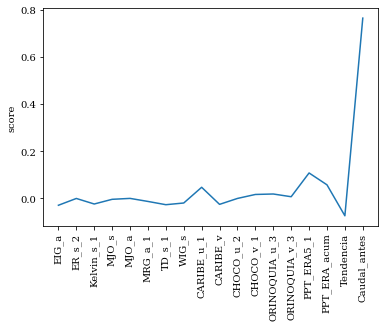

In [16]:
plt.plot(X.columns, sfm_selector.estimator_.coef_)
plt.xticks(rotation = 90)
plt.ylabel('score')
plt.savefig(ruta_imagenes+'Seleccion_variables_from_lr.png', bbox_inches='tight', dpi=150)

### Selección con modelo y validación cruzada

In [17]:
from sklearn.feature_selection import  SequentialFeatureSelector

In [18]:
sfs_selector = SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select = 10, cv =10, direction ='backward')
sfs_selector.fit(X, y)
X.columns[sfs_selector.get_support()]

Index(['EIG_a', 'TD_s_1', 'WIG_s', 'CARIBE_u_1', 'CARIBE_v', 'CHOCO_v_1',
       'PPT_ERA5_1', 'PPT_ERA_acum', 'Tendencia', 'Caudal_antes'],
      dtype='object')

### Selección de variables con ELI5

In [19]:
import eli5
from eli5.sklearn import PermutationImportance

In [20]:
model = LinearRegression()
model.fit(X,y)
perm = PermutationImportance(model, random_state=1).fit(X, y)
eli5.show_weights(model)

Weight?,Feature
+0.765,x17
+0.108,x14
+0.057,x15
+0.047,x8
+0.018,x12
+0.016,x11
+0.007,x13
+0.002,<BIAS>
-0.000,x4
-0.000,x10


### Selección con un modelo ensamblado

In [21]:
import shap
from sklearn.ensemble import RandomForestRegressor

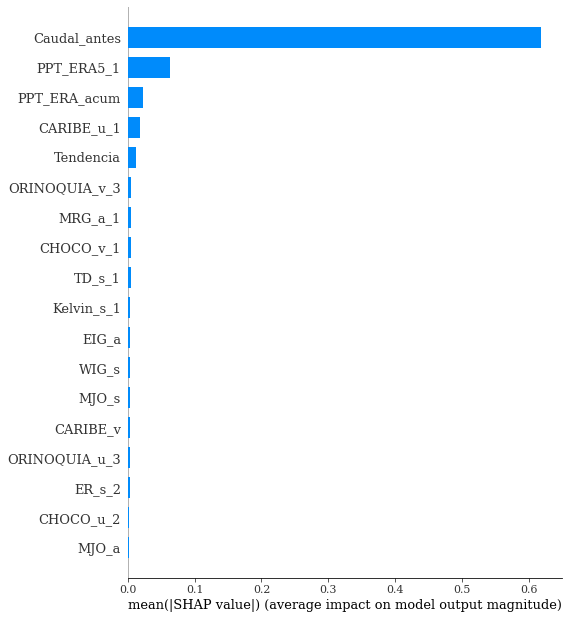

In [22]:
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X, y)
plt.figure(figsize=(10,10))
shap_values = shap.TreeExplainer(model).shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar",show=False)
plt.savefig(ruta_imagenes+'Seleccion_variables_from_rf.png', bbox_inches='tight', dpi=150)